# Feature Engineering

## 1. Data Preparation

#### Loading of Libraries

In [1]:
# General Data Cleaning/Stats
import pandas as pd
import numpy as np
import re
from datetime import datetime

# General Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn Stuffs (Mainly for Encoding)
from sklearn.preprocessing import OneHotEncoder # categorical variable so do one hot encoding

# Geosptial Visualisations
import geopandas as gpd #conda install geopandas
import plotly.express as px #conda install -c plotly plotly_express
import plotly.graph_objects as go

# NLP
import nltk # conda install -c anaconda nltk
from textblob import TextBlob
nltk.download('punkt')

# python script containing mapbox token (not uploaded on GitHub)
try:
    from tokens import mapbox_token
except:
    mapbox_token = '############### USE OWN MAPBOX TOKEN ###############'
    
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /Users/Chin2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
sns.set_palette("rocket")
pal = sns.color_palette("rocket")
hex_colors = pal.as_hex()
print(hex_colors)
pal

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

#### Reading in Scraped Datasets

In [3]:
df_restaurant = pd.read_csv("data/full_restaurant_rating_data.csv")
df_is_in_mall = pd.read_csv("data/restaurant_is_in_mall.csv")
df_walking_duration_from_station_exit = pd.read_csv("data/restaurant_walking_distance_from_station_exit.csv")
df_restaurant_nearest_exit = pd.read_csv('data/restaurant_nearest_station_exit.csv')
df_reviews = pd.read_csv('data/full_restaurant_review_data.csv', parse_dates=['date'])

In [4]:
# Merge all the Scraped Datasets into Restaurant Dataset
df_restaurant = df_restaurant.merge(df_is_in_mall[['url', 'is_in_mall', 'mall']], on='url', how='left')
df_restaurant = df_restaurant.merge(df_walking_duration_from_station_exit, on='url', how='left')
df_restaurant = df_restaurant.merge(df_restaurant_nearest_exit[['station_name', 'station_line_color', 'url', 'distance']], on='url', how='left')

#### Sample Data:

In [5]:
df_restaurant.loc[1,:]

name                                                      Entre-Nous creperie
address                     27 Seah Street # 01-01, Singapore 188383 Singa...
region                                                 Central Area/City Area
latitude                                                             1.296215
longitude                                                           103.85462
nearby_attraction                                          City Hall Building
distance_from_attraction                                                  0.4
price_category                                                      mid range
price_range                                                       S$13 - S$27
mon_operating_hours                                                       NaN
tue_operating_hours                                        12:00 PM - 2:30 PM
wed_operating_hours                                        12:00 PM - 2:30 PM
thu_operating_hours                                        12:00

## 2. Dropping of Restaurant with too little Number of Reviews

### Number of reviews histogram

0-2         3935
3-5         1578
6-10        1348
11-15        754
16-20        477
21-100      2062
101-200      497
201-300      177
301-400      109
401-500       67
501-600       50
601-700       39
701-800       14
801-900       14
901-1000       9
>1000         31
Name: reviews_bins, dtype: int64


<AxesSubplot:>

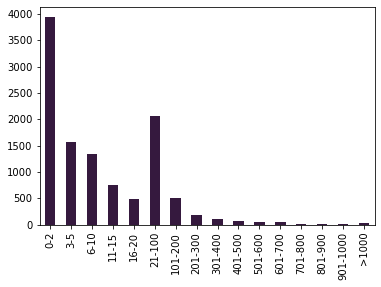

In [6]:
# this is to see how many 0 reviews are there in the dataset
# e.g. (-1, 2] = value of -1 is not included in this bin but a value of 0, 1 and 2 is included
reviews_bins = [-1, 2, 5, 10, 15, 20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 10000]
reviews_bins_labels = ['0-2', '3-5', '6-10', '11-15', '16-20', '21-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '>1000']

df_restaurant['reviews_bins'] = pd.cut(df_restaurant['num_of_reviews'], reviews_bins, labels = reviews_bins_labels)

# distribution of number_of_review in bins
print(df_restaurant['reviews_bins'].value_counts().sort_index())

# histogram of reviews
df_restaurant['reviews_bins'].value_counts().sort_index().plot.bar()

### Dropping rows with reviews <= 2 (dropping 3935 rows of data)

In [7]:
# dropping rows with reviews <= 2: dropping 3935 rows of data

df_restaurant = df_restaurant[df_restaurant['num_of_reviews'] >= 3]
df_restaurant.shape

(7226, 43)

## 3. Feature Engineering of Rating (Target Variable)

### Creating a new column in the dataframe called 'total_ratings' that is calculated from the summation of fields from 'num_of_ratings'

In [8]:
df_restaurant['total_ratings'] = df_restaurant['num_of_rating_1'] + df_restaurant['num_of_rating_2'] + df_restaurant['num_of_rating_3'] + df_restaurant['num_of_rating_4'] + df_restaurant['num_of_rating_5']

### Creating a new column in the dataframe called 'total_stars' that is calculated from the multiplication of fields from 'num_of_ratings'

In [9]:
df_restaurant['total_stars'] = (df_restaurant['num_of_rating_1'] * 1) + (df_restaurant['num_of_rating_2'] * 2) + (df_restaurant['num_of_rating_3'] * 3) + (df_restaurant['num_of_rating_4'] * 4) + (df_restaurant['num_of_rating_5'] * 5)   

### Creating a new column in the dataframe called 'average_rating' that is calculated from 'total_stars' / 'total_ratings'

In [10]:
df_restaurant['average_rating'] = round(df_restaurant['total_stars'] / df_restaurant['total_ratings'], 1)


### Visualizing the distribution of average_rating

<AxesSubplot:>

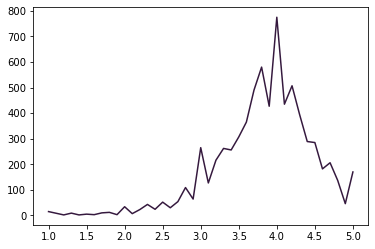

In [11]:
df_restaurant['average_rating'].value_counts().sort_index().plot()

### Viewing 'average_rating' in percentile order

In [12]:
for i in np.arange(0.1, 1.1, 0.1):
    print(f'Average Rating at {round(int(i*100), 2)} percentile: ' + str(round(df_restaurant['average_rating'].quantile(i), 2))) 

Average Rating at 10 percentile: 3.0
Average Rating at 20 percentile: 3.4
Average Rating at 30 percentile: 3.6
Average Rating at 40 percentile: 3.8
Average Rating at 50 percentile: 3.9
Average Rating at 60 percentile: 4.0
Average Rating at 70 percentile: 4.2
Average Rating at 80 percentile: 4.3
Average Rating at 90 percentile: 4.6
Average Rating at 100 percentile: 5.0


### Creating a new column in the dataframe called 'average_rating_category' to bin/categorise 'average_rating' as 0 for ratings below the 50th percentile and 1 for ratings above the 50th percentile

In [13]:
def rating_categories(df) :
    if (df['average_rating'] <= 3.9) or pd.isna(df['average_rating']):
        val = 0
    else:
        val = 1
    return val 

df_restaurant['average_rating_category'] = df_restaurant.apply(rating_categories, axis=1)

# Viewing the frequency count for the 'average_rating_category'
df_restaurant['average_rating_category'].value_counts()

0    3800
1    3426
Name: average_rating_category, dtype: int64

### Dropping Rows with missing Walking Distance (and Geolocations)

In [14]:
print(f"Total Rows: {len(df_restaurant)}")
print(f"Good Geolocations: {len(df_restaurant[df_restaurant['longitude'] > 100])}")
print(f"Bad Geolocations: {len(df_restaurant[df_restaurant['longitude'] < 100])}")  # outside of SG
print(f"Missing Geolocations: {len(df_restaurant[df_restaurant['longitude'].isna()])}")
print(f"Missing Walking Distance: {len(df_restaurant[df_restaurant['walking_distance'].isna()])}")

Total Rows: 7226
Good Geolocations: 7194
Bad Geolocations: 0
Missing Geolocations: 32
Missing Walking Distance: 34


In [15]:
df_restaurant = df_restaurant.dropna(subset=['walking_distance'])

## 4. Creating of new Region Feature (Replacing TripAdvisor's Region)

### Exploring Region feature scraped from TripAdvisor

- Region obtained from TripAdvisor is identified as a Problematic Feature
- The regions labeled are inconsistent (relative to the restaurant's true geographical location). For example a restaurant located in Marina Bay Sands could be assigned a region 'Marina Centre', and another could be assigned 'Central Area/City Area' 

In [16]:
print(f"Total Number of TripAdvisor Regions: {len(df_restaurant['region'].value_counts())}")
print("Percentage of Restaurants in these regions:")
print(df_restaurant['region'].value_counts().head(10) / len(df_restaurant) * 100)

Total Number of TripAdvisor Regions: 133
Percentage of Restaurants in these regions:
Central Area/City Area    19.035039
Outram                     9.607898
Bukit Merah                4.213014
Boulevard                  4.199110
Somerset                   3.072859
Marine Parade              3.031146
Bedok                      2.683537
Changi                     2.544494
Marina Centre              2.502781
City Hall                  2.169077
Name: region, dtype: float64


### Using Geospatial Information to engineer a "new" Region feature

#### Convert dataframe into a GeoDataFrame

In [17]:
gdf_restaurant = gpd.GeoDataFrame(df_restaurant, geometry= gpd.points_from_xy(df_restaurant['longitude'], df_restaurant['latitude']), crs='epsg:4326')

#### Loading a Subzones Shapefile Data
- Containing Geographical Boundary in Singapore (defined by Urban Redevelopment Authority URA)
- 3 Levels of Boundary: Area (e.g. East, West), Town (e.g. Bishan), District (e.g. Marymount)

In [18]:
gdf_subzones = gpd.read_file('data/singapore_subzones_2019.geojson', crs='epsg:4326')
gdf_subzones['extracted_description'] = gdf_subzones['Description'].apply(
    lambda x: re.findall("(?<=<td>)[\w*\s*\-*]*\w+(?=</td>)", x)
)

def extract_district(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[1]
        else:
            np.nan
    else:
        return np.nan

def extract_town(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[4]
        else:
            return x[3]
    else:
        return np.nan

def extract_region(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[6]
        else:
            return x[5]
    else:
        return np.nan

gdf_subzones['district'] = gdf_subzones['extracted_description'].apply(lambda x: extract_district(x))
gdf_subzones['town'] = gdf_subzones['extracted_description'].apply(lambda x: extract_town(x))
gdf_subzones['area'] = gdf_subzones['extracted_description'].apply(lambda x: extract_region(x))        

gdf_subzones.drop(columns=['Name', 'Description', 'extracted_description'], inplace=True)

#### Geospatial Join of Region Dataset to map District/Town/Area that each restaurant is located in

In [19]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_subzones,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)

#### Handling Missing District/Town/Area
- It is identified from Geospatial Visualisation that the restaurants that are not mapped to any geographical boundaries are located offshore. Hence the district/town/area of these restaurants are imputed based on the nearest boundary from the restaurant

In [20]:
gdf_restaurant_missing_location = gdf_restaurant[gdf_restaurant['area'].isna()].copy()
gdf_restaurant_missing_location

,name,address,region,latitude,longitude,nearby_attraction,distance_from_attraction,price_category,price_range,mon_operating_hours,...,distance,reviews_bins,total_ratings,total_stars,average_rating,average_rating_category,geometry,district,town,area
2537,Goldenbeach Seafood Paradise,907 East Coast Road #01-01 Springvale Springva...,NaN,1.391251,103.97471,NaN,NaN,mid range,S$27 - S$54,11:30 AM - 3:00 PM,...,3481.244390,21-100,25,96,3.8,0,POINT (103.97471 1.39125),NaN,NaN,NaN
2754,Rasa Istimewa,"6A Admiralty Road West Waterfront Park, Singap...",NaN,1.453914,103.77774,Singapore Zoo,5.8,mid range,[],NaN,...,2116.644183,21-100,35,130,3.7,0,POINT (103.77774 1.45391),NaN,NaN,NaN
2815,Patro's Sports Bar & Restaurant,920 East Coast Parkway Parkland Green #01-18/1...,NaN,1.298121,103.90860,East Coast Park,0.7,mid range,S$40 - S$67,NaN,...,2441.963490,21-100,52,191,3.7,0,POINT (103.90860 1.29812),NaN,NaN,NaN
5070,Stewords Riverboat,31 Marina Coastal Drive Marina South Pier Bert...,NaN,1.270886,103.86388,Marina Bay,1.5,NaN,[],NaN,...,69.574040,6-10,6,21,3.5,0,POINT (103.86388 1.27089),NaN,NaN,NaN


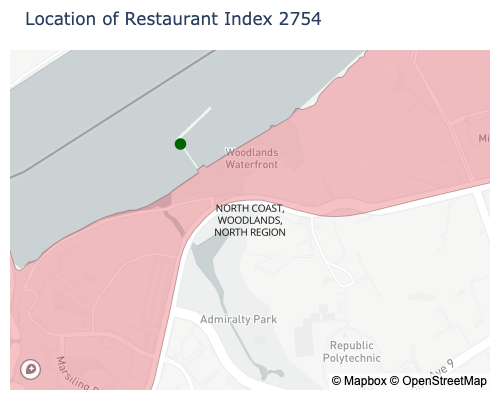

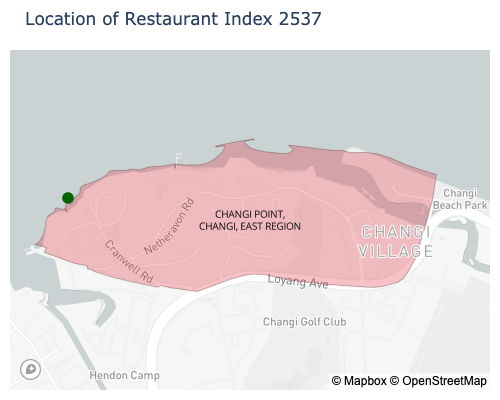

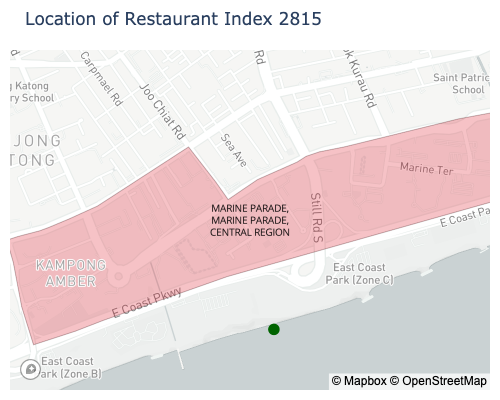

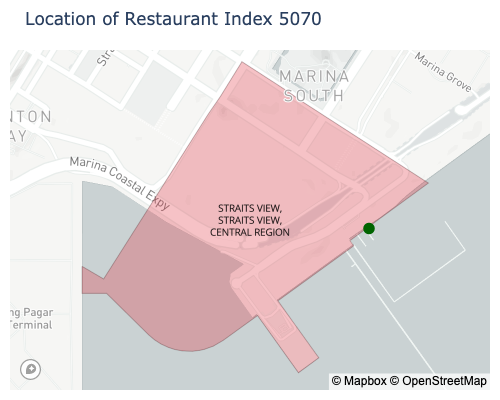

In [21]:
for res_id, region_id in [(2754, 323), (2537, 258), (2815, 93), (5070, 12)]:
    gdf_subset_subzones = gdf_subzones[gdf_subzones.index == region_id]
    fig = px.choropleth_mapbox(
        gdf_subset_subzones,
        geojson=gdf_subset_subzones.geometry,
        locations=gdf_subset_subzones.index,
        opacity=0.3,
        color=gdf_subset_subzones.district,
        color_discrete_map={gdf_subset_subzones.loc[:,'district'].iloc[0]: hex_colors[3]},
        zoom=13, # 11.2 for CBD  
        labels={'district': 'District', 'town': 'Town', 'area': 'Area'},
    )

    fig.update_traces(showlegend=False)

    fig2 = go.Figure(go.Scattermapbox(
        mode="markers",
        lat=gdf_restaurant_missing_location['latitude'],
        lon=gdf_restaurant_missing_location['longitude'],
        marker= {"size": 12, "color": "darkgreen"},
    ))

    fig3 = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_subset_subzones.centroid.y,
        lon=gdf_subset_subzones.centroid.x,
        text=f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
    ))

    fig3.update_layout(
        width=500,
        height=400,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= gdf_subset_subzones.iloc[0,:].geometry.centroid.y,
                lon= gdf_subset_subzones.iloc[0,:].geometry.centroid.x,        
            ), zoom=14),        
        title=f"Location of Restaurant Index {res_id}",
        margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
        mapbox_accesstoken=mapbox_token,
        # mapbox= {'style': 'outdoors'},
        showlegend=False,        
    )

    fig3.update_traces(
        showlegend=False,
        mode="text", 
        text= 
        f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
        textfont=dict(size=10, color='black')
    )

    fig3.add_trace(fig2.data[0])
    fig3.add_trace(fig.data[0])

    fig3.show("png")

In [22]:
gdf_restaurant.loc[2537, 'district'] = 'CHANGI POINT'
gdf_restaurant.loc[2537, 'town'] = 'CHANGI'
gdf_restaurant.loc[2537, 'area'] = 'EAST REGION'

gdf_restaurant.loc[2754, 'district'] = 'NORTH COAST'
gdf_restaurant.loc[2754, 'town'] = 'WOODLANDS'
gdf_restaurant.loc[2754, 'area'] = 'NORTH REGION'

gdf_restaurant.loc[2815, 'district'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'town'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'area'] = 'CENTRAL REGION'

gdf_restaurant.loc[5070, 'district'] = 'STRAITS VIEW'
gdf_restaurant.loc[5070, 'town'] = 'STRAITS VIEW'
gdf_restaurant.loc[5070, 'area'] = 'CENTRAL REGION'

#### Visualising Number of Restaurants in each Area
- With the 3 layers of boundaries, we will inspect layer by layer to identify the boundary best suited for our project, beginning with the largest boundary, Area (North Region, North-East Region, East Region, Central Region, West Region)
- We will visualise the number of restaurants in our dataset within each boundary. We aim to ensure that the new "region" we engineered is fairly distributed and not skewed towards any particular label

In [23]:
# aggregating District boundaries to form Area boundary
df_region_area_rating = gdf_restaurant.groupby(['area']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_area_rating.columns = df_region_area_rating.columns.droplevel(1)
df_region_area_rating.reset_index(drop=False, inplace=True)
df_region_area_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_area = gdf_subzones.dissolve(by='area').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_area_rating = df_region_area_rating.merge(gdf_area, on='area', how='left')
gdf_region_area_rating = gpd.GeoDataFrame(df_region_area_rating, geometry='geometry', crs='epsg:4326')

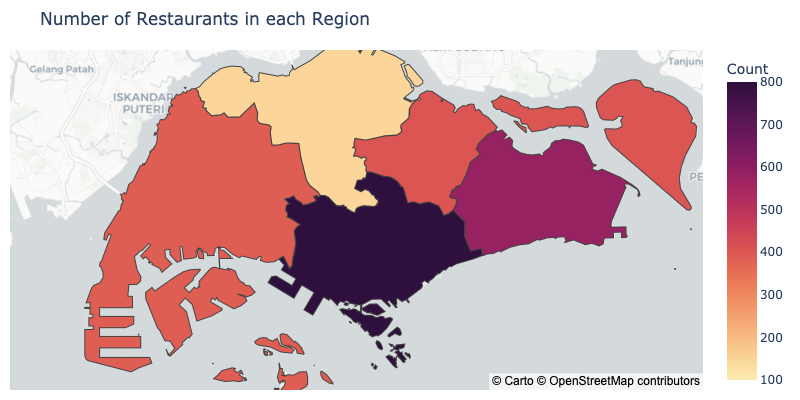

In [24]:
fig = px.choropleth_mapbox(
    gdf_region_area_rating,
    geojson = gdf_region_area_rating.geometry,
    locations = gdf_region_area_rating.index,
    labels={
        'num_of_restaurants': 'Count'
    },
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(100,800),
    hover_data=['area'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

- The Central Region has overwhelmingly more restaurants than the other regions. 
- The East Region has the second most number of restaurants and is significantly greater than that of the West and North-East Region
- The North Region has the least region among all areas

#### Number of Restaurants within the Towns in the Central and East Regions
- Due to the unequal distribution as shown above, we will like to "break" the Central and East region into smaller boundaries so that the sub-boundaries have a number of restaurants that is closer to that of the North, North-East and West Regions.
- We will next look into the Town boundaries of the Central and East Regions.

In [25]:
# aggregating District boundaries to form Town boundary

df_region_town_rating = gdf_restaurant.groupby(['town']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_town_rating.columns = df_region_town_rating.columns.droplevel(1)
df_region_town_rating.reset_index(drop=False, inplace=True)
df_region_town_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_town = gdf_subzones.dissolve(by='town').reset_index(drop=False)[['town', 'area', 'geometry']]
gdf_region_town_rating = df_region_town_rating.merge(gdf_town, on='town', how='left')
gdf_region_town_rating = gpd.GeoDataFrame(gdf_region_town_rating, geometry='geometry', crs='epsg:4326')

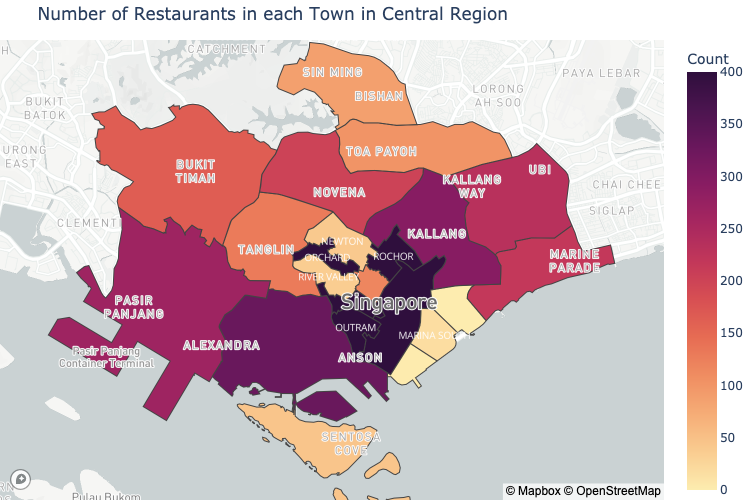

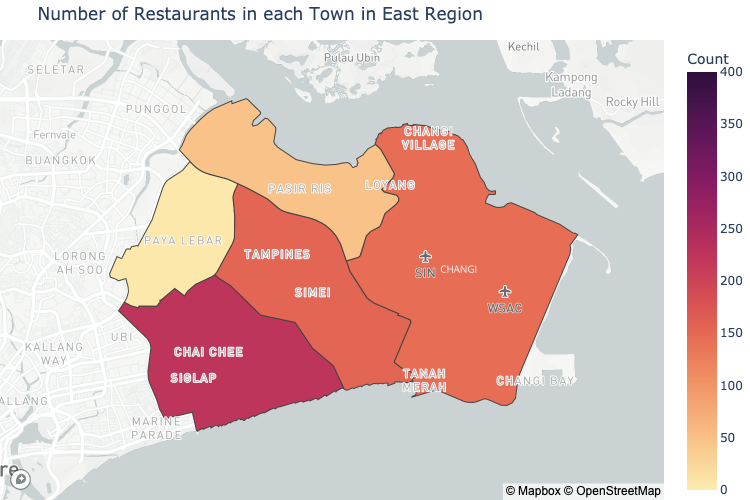

In [26]:
for i in [('CENTRAL REGION', 1.3, 103.835, 'Central'), ('EAST REGION', 1.35, 103.96, 'East')]:
    gdf_region_town_rating_subset = gdf_region_town_rating[gdf_region_town_rating['area'] == i[0]].copy()
    fig_text = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_region_town_rating_subset.centroid.y,
        lon=gdf_region_town_rating_subset.centroid.x,
        text=gdf_region_town_rating_subset['town'],
        textfont=dict(size=10, color='white')
    ))

    fig = px.choropleth_mapbox(
        gdf_region_town_rating_subset,
        geojson = gdf_region_town_rating_subset.geometry,
        locations = gdf_region_town_rating_subset.index,
        color='num_of_restaurants',
        color_continuous_scale='matter',
        range_color=(0,400),
        hover_data=['town', 'area'],
        labels={'num_of_restaurants': 'Count'}
    )    

    fig.update_layout(
        width=750,
        height=500,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= i[1],
                lon= i[2],
            ), zoom=11.2),
        mapbox_accesstoken=mapbox_token,
        title=f"Number of Restaurants in each Town in {i[3]} Region",
        margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
        showlegend=False,        
    )

    fig.add_traces(fig_text.data[0])
    fig.show("png")

In [27]:
gdf_region_town_rating_central = gdf_region_town_rating[gdf_region_town_rating['area'] == 'CENTRAL REGION'].copy()
gdf_region_town_rating_central.sort_values(['num_of_restaurants'], ascending=False, inplace=True)
gdf_region_town_rating_central.reset_index(drop=True, inplace=True)

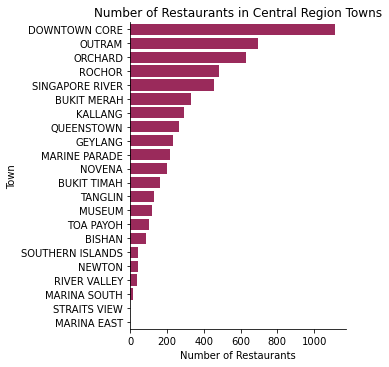

In [28]:
ax = sns.catplot(
    y = 'town',
    x = 'num_of_restaurants',
    data = gdf_region_town_rating_central,
    kind='bar',
    color=hex_colors[2]
)

ax.fig.gca().set_title("Number of Restaurants in Central Region Towns")
ax.fig.gca().set_ylabel("Town")
ax.fig.gca().set_xlabel("Number of Restaurants")
plt.show()

- In the Central Region, Downtown Core has a much larger number of restaurants than the other towns. We will take a closer look at the districts within the Downtown Core next.
- For towns that have very few counts such as Straits View and Marina East, they will be "merged" into towns.
- In the East Region, Bedok has the largest number of restaurants. The differences in counts across the towns is smaller than that of Central Region. Paya lebar and Pasir Ris will be merged into the Tampines town as they have slightly fewer counts of restaurants.

#### Further Breaking Down Downtown Core into Districts

In [29]:
df_region_district_rating = gdf_restaurant.groupby(['district']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_district_rating.columns = df_region_district_rating.columns.droplevel(1)
df_region_district_rating.reset_index(drop=False, inplace=True)
df_region_district_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_district = gdf_subzones.dissolve(by='district').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_district_rating = df_region_district_rating.merge(gdf_district, on='district', how='left')
gdf_region_district_rating = gpd.GeoDataFrame(df_region_district_rating, geometry='geometry', crs='epsg:4326')

gdf_region_district_rating_downtown = gdf_region_district_rating[gdf_region_district_rating['town'] == 'DOWNTOWN CORE']

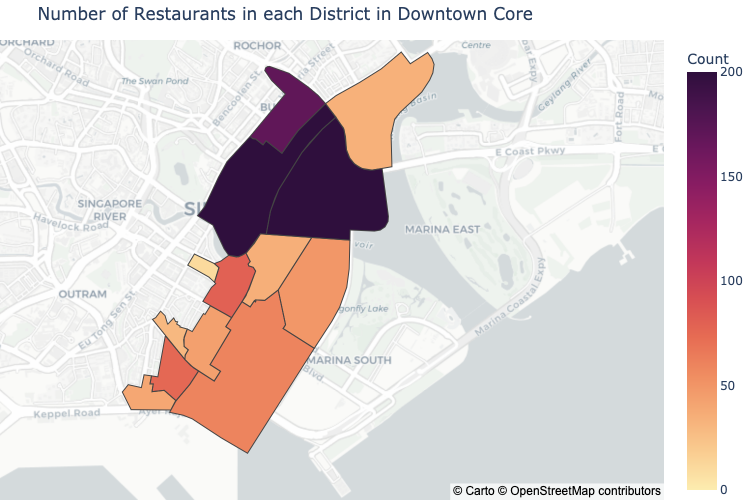

In [30]:
fig = px.choropleth_mapbox(
    gdf_region_district_rating_downtown,
    geojson = gdf_region_district_rating_downtown.geometry,
    locations = gdf_region_district_rating_downtown.index,
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(0,200),
    hover_data=['town', 'area', 'district'],
    width=750,
    height=500,
        labels={
        'num_of_restaurants': 'Count'
    }, 
    center= {
        'lat': 1.285,
        'lon': 103.86
    },
    zoom=12.95 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each District in Downtown Core",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

# BUGIS + CITY HALL
# MARINA CENTRE + NICOLL
# REMAINING --> Downtown Core

- The Districts in the northern regions have more restaurants than those of the southern region. The districts in the southern region will then be grouped together.

#### Using District/Towns to Engineer a new Region Label

In [31]:
# ---------------------------------------------- #
gdf_town_paya_lebar_tampines_pasir_ris = gdf_town[gdf_town['town'].isin([
    'PAYA LEBAR', 'TAMPINES', 'PASIR RIS'])]

gdf_town_paya_lebar_tampines_pasir_ris = gdf_town_paya_lebar_tampines_pasir_ris.dissolve('area').reset_index(drop=False)
gdf_town_paya_lebar_tampines_pasir_ris.loc[0, 'town'] = 'PAYA LEBAR, TAMPINES, PASIR RIS'

# ---------------------------------------------- #
gdf_town_bishan_toa_payoh = gdf_town[gdf_town['town'].isin([
    'BISHAN', 'TOA PAYOH'])]

gdf_town_bishan_toa_payoh = gdf_town_bishan_toa_payoh.dissolve('area').reset_index(drop=False)
gdf_town_bishan_toa_payoh.loc[0, 'town'] = 'BISHAN, TOA PAYOH'

# ---------------------------------------------- #
gdf_town_rochor = gdf_town[gdf_town['town'].isin([
    'MUSEUM', 'ROCHOR'])]

gdf_town_rochor = gdf_town_rochor.dissolve('area').reset_index(drop=False)
gdf_town_rochor.loc[0, 'town'] = 'ROCHOR'

# ---------------------------------------------- #
gdf_town_singapore_river = gdf_town[gdf_town['town'].isin([
    'RIVER VALLEY', 'SINGAPORE RIVER'])]

gdf_town_singapore_river = gdf_town_singapore_river.dissolve('area').reset_index(drop=False)
gdf_town_singapore_river.loc[0, 'town'] = 'SINGAPORE RIVER'

# ---------------------------------------------- #
gdf_town_newtown_orchard = gdf_town[gdf_town['town'].isin([
    'NEWTON', 'ORCHARD'])]

gdf_town_newtown_orchard = gdf_town_newtown_orchard.dissolve('area').reset_index(drop=False)
gdf_town_newtown_orchard.loc[0, 'town'] = 'NEWTON, ORCHARD'

# ---------------------------------------------- #
gdf_town_bukit_merah_southern_islands = gdf_town[gdf_town['town'].isin([
    'BUKIT MERAH', 'SOUTHERN ISLANDS'])]

gdf_town_bukit_merah_southern_islands = gdf_town_bukit_merah_southern_islands.dissolve('area').reset_index(drop=False)
gdf_town_bukit_merah_southern_islands.loc[0, 'town'] = 'BUKIT MERAH, SOUTHERN ISLANDS'

# ---------------------------------------------- #
gdf_town_marina_bay = gdf_town[gdf_town['town'].isin([
    'MARINE PARADE', 'MARINA EAST', 'MARINA SOUTH', 'STRAITS VIEW'])]

gdf_town_marina_bay = gdf_town_marina_bay.dissolve('area').reset_index(drop=False)
gdf_town_marina_bay.loc[0, 'town'] = 'MARINA BAY'

# ---------------------------------------------- #
gdf_district_bugis_city_hall = gdf_district[gdf_district['district'].isin([
    'BUGIS', 'CITY HALL'])]

gdf_district_bugis_city_hall = gdf_district_bugis_city_hall.dissolve('area').reset_index(drop=False)
gdf_district_bugis_city_hall.loc[0, 'district'] = 'BUGIS, CITY HALL'

# ---------------------------------------------- #
gdf_district_marina_centre = gdf_district[gdf_district['district'].isin([
    'NICOLL', 'MARINA CENTRE'])]

gdf_district_marina_centre = gdf_district_marina_centre.dissolve('area').reset_index(drop=False)
gdf_district_marina_centre.loc[0, 'district'] = 'MARINA CENTRE'

# ---------------------------------------------- #
gdf_district_downtown = gdf_district[
    ~(gdf_district['district'].isin(['NICOLL', 'MARINA CENTRE', 'BUGIS', 'CITY HALL'])) &
    (gdf_district['town'] == 'DOWNTOWN CORE')
]

gdf_district_downtown = gdf_district_downtown.dissolve('area').reset_index(drop=False)
gdf_district_downtown.loc[0, 'district'] = 'DOWNTOWN'

In [32]:
gdf_area_excluding_central_east = gdf_area[~gdf_area['area'].isin(['EAST REGION', 'CENTRAL REGION'])]
gdf_area_excluding_central_east = gdf_area_excluding_central_east[['geometry', 'area']].rename(columns={'area': 'new_region_feature'})

# ---------------------------------------------- #
gdf_town_changi_bedok = gdf_town[gdf_town['town'].isin([
                                'CHANGI', 'BEDOK'])]

gdf_town_changi_bedok = gdf_town_changi_bedok[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})                               

# ---------------------------------------------- #
gdf_town_central =gdf_town[
    (gdf_town['area'] == 'CENTRAL REGION') &
    ~(gdf_town['town'].isin([
        'BISHAN', 'TOA PAYOH', 'MUSEUM', 'ROCHOR', 'RIVER VALLEY',
        'SINGAPORE RIVER', 'NEWTON', 'ORCHARD', 'MARINE PARADE', 'MARINA EAST',
        'MARINA SOUTH', 'STRAITS VIEW', 'BUKIT MERAH', 'SOUTHERN ISLANDS','DOWNTOWN CORE'
    ]))
]

gdf_town_central = gdf_town_central[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})

In [33]:
gdf_new_region = pd.concat([
    gdf_area_excluding_central_east,
    gdf_town_changi_bedok,
    gdf_town_central,
    gdf_town_paya_lebar_tampines_pasir_ris[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bishan_toa_payoh[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_rochor[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_singapore_river[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_newtown_orchard[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bukit_merah_southern_islands[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_marina_bay[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_district_bugis_city_hall[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_marina_centre[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_downtown[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
])

gdf_new_region.reset_index(drop=True, inplace=True)

In [34]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_new_region,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)
gdf_restaurant.loc[2537, 'new_region_feature'] = 'CHANGI'
gdf_restaurant.loc[2754, 'new_region_feature'] = 'NORTH REGION'
gdf_restaurant.loc[2815, 'new_region_feature'] = 'MARINA BAY'
gdf_restaurant.loc[5070, 'new_region_feature'] = 'MARINA BAY'

#### Inspecting New Region

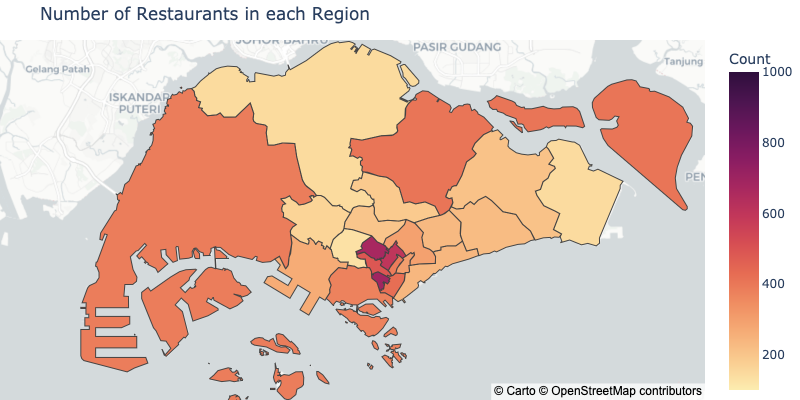

In [35]:
df_new_region = gdf_restaurant.groupby(['new_region_feature']).agg({
    'url': ['count'],
    'mall': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
    'num_of_reviews': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_new_region.columns = df_new_region.columns.droplevel(1)
df_new_region.reset_index(drop=False, inplace=True)
df_new_region.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
    'num_of_reviews':'average_num_of_reviews'
}, inplace=True)

gdf_new_region = gdf_new_region.merge(df_new_region, on='new_region_feature', how='left')

fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(100,1000),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'num_of_restaurants': 'Count'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

- Number of restaurants in each region is less unbalanced in the new Region feature

In [36]:
gdf_restaurant.drop(columns=["region", "district", "town", "area"], inplace=True)
gdf_restaurant.rename(columns={"new_region_feature": "region"}, inplace=True)
gdf_restaurant.reset_index(drop=True, inplace=True)

In [37]:
# save a copy of the df first [for exporting for EDA]
gdf_restaurant_copy = gdf_restaurant.copy()

In [38]:
gdf_restaurant['region'] = gdf_restaurant['region'].str.lower().str.replace('-', '').str.replace(',','').str.replace(' ', '_')

In [39]:
print(f"Total Number of Engineered Regions: {len(gdf_restaurant['region'].value_counts())}")
print("Percentage of Restaurants in these regions:")
print(gdf_restaurant['region'].value_counts().head(10) / len(gdf_restaurant) * 100)

Total Number of Engineered Regions: 22
Percentage of Restaurants in these regions:
outram                          9.649611
newton_orchard                  9.343715
rochor                          8.384316
singapore_river                 6.813126
downtown                        5.909344
northeast_region                5.659066
bugis_city_hall                 5.422692
west_region                     5.380979
bukit_merah_southern_islands    5.214127
marina_centre                   4.171301
Name: region, dtype: float64


In [40]:
region_enc = OneHotEncoder(categories='auto')
features_region = region_enc.fit_transform(gdf_restaurant[['region']])

In [41]:
region_ohe_columns = region_enc.get_feature_names_out(['region'])
region_ohe_df = pd.DataFrame(features_region.toarray(), columns=region_ohe_columns)
gdf_restaurant = pd.concat([gdf_restaurant, region_ohe_df], axis=1)

In [42]:
gdf_restaurant.iloc[:2,-15:]

,region_geylang,region_kallang,region_marina_bay,region_marina_centre,region_newton_orchard,region_north_region,region_northeast_region,region_novena,region_outram,region_paya_lebar_tampines_pasir_ris,region_queenstown,region_rochor,region_singapore_river,region_tanglin,region_west_region
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Price Category 

### Checking Unique Price Category

In [43]:
gdf_restaurant['price_category'].unique()

array(['mid range', 'fine dining', 'cheap eats', nan], dtype=object)

### Creation of Column to Indicate if Price Category is missing

In [44]:
gdf_restaurant["has_price_category"] = np.where(gdf_restaurant['price_category'].isna(), 0, 1)

print("Missing Price Category:")
print(gdf_restaurant[gdf_restaurant["has_price_category"]==0].price_category.unique())

print("Not Missing Price Category:")
print(gdf_restaurant[gdf_restaurant["has_price_category"]==1].price_category.unique())

Missing Price Category:
[nan]
Not Missing Price Category:
['mid range' 'fine dining' 'cheap eats']


### Converting Price Category into Ordinal Variable

In [45]:
category_mapper = {np.nan: 0, "cheap eats":1, "mid range":2, "fine dining":3}
gdf_restaurant["ordinal_price_category"] = gdf_restaurant["price_category"].map(category_mapper)
print(gdf_restaurant["ordinal_price_category"].unique())

[2 3 1 0]


## 6. Nearby Attractions and Distance from Attractions

### Grouping of Similar Types of Nearby Attraction

In [46]:
gdf_restaurant["nearby_attraction"] = gdf_restaurant['nearby_attraction'].replace(to_replace =['Asian Civilisations Museum', 'National Museum of Singapore', 'City Hall Building'], value ="Museum")
gdf_restaurant["nearby_attraction"] = gdf_restaurant['nearby_attraction'].replace(to_replace =['National Orchid Garden', 'Singapore Botanic Gardens'], value ="Garden")
gdf_restaurant["nearby_attraction"] = gdf_restaurant['nearby_attraction'].replace(to_replace =['Singapore Cable Car', 'Singapore Flyer'], value ="Observation")
gdf_restaurant["nearby_attraction"] = gdf_restaurant['nearby_attraction'].replace(to_replace =['Night Safari', 'Singapore Zoo'], value ="Wildlife")

In [47]:
# harmonizing attraction names
gdf_restaurant['nearby_attraction'] = gdf_restaurant['nearby_attraction'].str.replace(" ", "_")
gdf_restaurant['nearby_attraction'] = gdf_restaurant['nearby_attraction'].str.lower()

In [48]:
# count by nearby attraction check
gdf_restaurant.groupby(['nearby_attraction'], dropna=False)['url'].count()

nearby_attraction
arab_street         179
boat_quay           128
chinatown           957
east_coast_park     570
garden              900
little_india        857
marina_bay          318
merlion_park        282
museum              404
observation         360
orchard_road        558
wildlife            227
NaN                1452
Name: url, dtype: int64

### Assigning Restaurant to Above Median/Below Median of its distance away from its Nearby Attraction

In [49]:
median_by_attraction = gdf_restaurant.groupby(['nearby_attraction']).agg({'distance_from_attraction': ['min', 'max', 'median']})['distance_from_attraction']['median'].to_dict()
gdf_restaurant["above_median"] =  gdf_restaurant[['distance_from_attraction', 'nearby_attraction']].apply(lambda x: x['distance_from_attraction'] > median_by_attraction[x['nearby_attraction']] if not pd.isna(x['nearby_attraction']) else np.nan, axis=1)
gdf_restaurant["above_median"] = gdf_restaurant["above_median"].astype(float)

In [50]:
gdf_restaurant["above_median"].unique()

array([ 1.,  0., nan])

### Encoding of Nearby Attraction Feature

In [51]:
nearby_attraction_enc = OneHotEncoder(categories='auto')
# One hot encoding for categorical variable
features_nearby_attraction_train = nearby_attraction_enc.fit_transform(gdf_restaurant[['nearby_attraction']])

# TODO transform on test

In [52]:
nearby_attraction_ohe_columns = nearby_attraction_enc.get_feature_names_out(['nearby_attraction'])
nearby_attraction_ohe_df = pd.DataFrame(features_nearby_attraction_train.toarray(), columns=nearby_attraction_ohe_columns)
gdf_restaurant = pd.concat([gdf_restaurant, nearby_attraction_ohe_df], axis=1)

In [53]:
gdf_restaurant.iloc[:3, 52:]

,region_bukit_timah,region_changi,region_downtown,region_geylang,region_kallang,region_marina_bay,region_marina_centre,region_newton_orchard,region_north_region,region_northeast_region,...,nearby_attraction_east_coast_park,nearby_attraction_garden,nearby_attraction_little_india,nearby_attraction_marina_bay,nearby_attraction_merlion_park,nearby_attraction_museum,nearby_attraction_observation,nearby_attraction_orchard_road,nearby_attraction_wildlife,nearby_attraction_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Feature Cross of above_median and nearby attraction

In [54]:
cross_cols = []
gdf_restaurant["above_median"] = gdf_restaurant["above_median"].replace(np.nan, 0)
for col in nearby_attraction_ohe_columns:
    if col == 'nearby_attraction_nan':
        continue
    cross = col + "_above_median"
    gdf_restaurant[cross] = gdf_restaurant[col] * gdf_restaurant["above_median"]
    cross_cols.append(cross)

In [55]:
for i in nearby_attraction_ohe_columns:
    print(f"{i}: {gdf_restaurant[i].unique()}")

nearby_attraction_arab_street: [0. 1.]
nearby_attraction_boat_quay: [0. 1.]
nearby_attraction_chinatown: [1. 0.]
nearby_attraction_east_coast_park: [0. 1.]
nearby_attraction_garden: [0. 1.]
nearby_attraction_little_india: [0. 1.]
nearby_attraction_marina_bay: [0. 1.]
nearby_attraction_merlion_park: [0. 1.]
nearby_attraction_museum: [0. 1.]
nearby_attraction_observation: [0. 1.]
nearby_attraction_orchard_road: [0. 1.]
nearby_attraction_wildlife: [0. 1.]
nearby_attraction_nan: [0. 1.]


In [56]:
for i in cross_cols:
    print(f"{i}: {gdf_restaurant[i].unique()}")

nearby_attraction_arab_street_above_median: [0. 1.]
nearby_attraction_boat_quay_above_median: [0. 1.]
nearby_attraction_chinatown_above_median: [1. 0.]
nearby_attraction_east_coast_park_above_median: [0. 1.]
nearby_attraction_garden_above_median: [0. 1.]
nearby_attraction_little_india_above_median: [0. 1.]
nearby_attraction_marina_bay_above_median: [0. 1.]
nearby_attraction_merlion_park_above_median: [0. 1.]
nearby_attraction_museum_above_median: [0. 1.]
nearby_attraction_observation_above_median: [0. 1.]
nearby_attraction_orchard_road_above_median: [0. 1.]
nearby_attraction_wildlife_above_median: [0. 1.]


## 7. Engineering Features, Cuisines, Meals, Diets

In [57]:
def clean_list(list_):
    list_ = list_.replace(', ', '","')
    if list_ != '[]':
        list_ = '["' + list_ + '"]'
    return list_

In [58]:
gdf_restaurant["list_of_meals"] = gdf_restaurant["list_of_meals"].apply(clean_list).apply(eval)
gdf_restaurant["list_of_cuisines"] = gdf_restaurant["list_of_cuisines"].apply(clean_list).apply(eval)
gdf_restaurant["list_of_features"] = gdf_restaurant["list_of_features"].apply(clean_list).apply(eval)
gdf_restaurant["list_of_special_diets"] = gdf_restaurant["list_of_special_diets"].apply(clean_list).apply(eval)

#### Indexing each Features, Cuisines, Meals and Diets

In [59]:
meals_dict = {}
for i in gdf_restaurant["list_of_meals"]:
    for j in i:
        if j not in meals_dict:
            meals_dict[j] = 1
        else:
            meals_dict[j] += 1

cuisines_dict = {}
for i in gdf_restaurant["list_of_cuisines"]:
    for j in i:
        if j not in cuisines_dict:
            cuisines_dict[j] = 1
        else:
            cuisines_dict[j] += 1

features_dict = {}
for i in gdf_restaurant["list_of_features"]:
    for j in i:
        if j not in features_dict:
            features_dict[j] = 1
        else:
            features_dict[j] += 1

diets_dict = {}
for i in gdf_restaurant["list_of_special_diets"]:
    for j in i:
        if j not in diets_dict:
            diets_dict[j] = 1
        else:
            diets_dict[j] += 1

#### One-Hot Encoding of Features, Meals, Cuisines and Diets

In [60]:
def ohc(key,list):
    if key in list:
        return 1
    return 0

def exists(list):
    if bool(list):
        return 1
    return 0

##### Meals

In [61]:
for key in meals_dict:
    gdf_restaurant[f'Meal {key}'] = gdf_restaurant["list_of_meals"].apply(lambda x: ohc(key,x))
gdf_restaurant['has_meals'] = gdf_restaurant["list_of_meals"].apply(exists)

In [62]:
gdf_restaurant.iloc[:2,-7:]

,Meal Lunch,Meal Dinner,Meal Drinks,Meal Breakfast,Meal Brunch,Meal After-hours,has_meals
0,1,1,1,0,0,0,1
1,1,1,1,0,0,0,1


##### Cuisines

In [63]:
establishment_types = {'Bar': 620,
 'Cafe': 812,
  'Wine Bar': 132,
   'Brew Pub': 26,
    'Steakhouse': 140,
 'Grill': 165,
  'Pub': 442,
   'Dining bars': 49,
    'Diner': 55,
     'Gastropub': 53,
      'Fast food': 279,
 'Deli': 49,
  'Beer restaurants': 31,
   'Fruit parlours': 7,
}.keys()
establishment_types = list(establishment_types)

In [64]:
def find(to_find, list):
    try:
        return list.index(to_find), to_find
    except ValueError:
        return 10000, None

In [65]:
establishment = []
for index, row in gdf_restaurant.iterrows():
    estab = (min(find(establishment_type,row["list_of_cuisines"]) for establishment_type in establishment_types))
    establishment.append(estab[1])
gdf_restaurant["establishment_type"] = establishment

In [66]:
cuisines = {
'Pizza': 263,'Italian': 453,'French': 192,'European': 501, #'Healthy': 218,
'Japanese': 1070, 'Indian': 480,'International': 355,'Singaporean': 1405,
 'Chinese': 1798,'Asian': 3837,'Mediterranean': 157,'Turkish': 36,
 'Middle Eastern': 82,'German': 23,'Central European': 16,
 'Sicilian': 2,'Southern-Italian': 9,'Northern-Italian': 3,
 'Central-Italian': 9,#'Seafood': 591,
 'Lebanese': 29,#'Barbecue': 197,
 'Arabic': 16,'Sushi': 330,'Japanese Fusion': 42,#'Fusion': 373,
 'Caucasian': 15,'Contemporary': 129,'American': 441,#'Street Food': 71,
 'Thai': 383,#'Soups': 170,
 'Neapolitan': 5,'Campania': 5,'Southwestern': 57,
 'Egyptian': 4,'Irish': 10,'Spanish': 71,'Greek': 18,'British': 47,
 'Russian': 4,'Eastern European': 6,'Ukrainian': 1,'Tuscan': 4,
 'New Zealand': 5,'Vietnamese': 112,'Indonesian': 125,'Taiwanese': 83,
 'Korean': 254,'Kaiseki': 7,'Persian': 7,'Swiss': 13,'Australian': 56,
 'Mexican': 61,'Cajun & Creole': 6,'Peruvian': 3,'South American': 18,
 'Brazilian': 7,'Pakistani': 13,'Malaysian': 226,'Latin': 17,'Dutch': 2,
 'Caribbean': 5,'Jamaican': 1,'Central Asian': 23,'Yunnan': 4,'Central American': 14,
'Medicinal foods': 2,'Nepalese': 7,'Argentinian': 2,'Austrian': 3,'Sri Lankan': 3,
 'Israeli': 5,'Scandinavian': 6,'Swedish': 8,'Portuguese': 10,'Catalan': 1,
 'Scottish': 2,'Tibetan': 1,'Hawaiian': 10,'Hokkaido cuisine': 5,
 'Belgian': 3,'Czech': 1,'Afghani': 4,'Burmese': 2,'African': 3,
 'Japanese sweets parlour': 6,'Cuban': 4,'Philippine': 12,'Chilean': 1,
 'Moroccan': 3,'Bangladeshi': 2,'Albanian': 1,'Mongolian': 2,'Fujian': 4,
 'Kappo': 3,'Beijing cuisine': 3,'Danish': 1,'Canadian': 2,'Azerbaijani': 1,
 'Kyoto cuisine': 1,'Armenian': 1,'Norwegian': 1,'Native American': 1,
 'Xinjiang': 2}
cuisines = list(cuisines.keys())

In [67]:
cuisine = []
for index, row in gdf_restaurant.iterrows():
    cui = (min(find(cuisine,row["list_of_cuisines"]) for cuisine in cuisines))
    cuisine.append(cui[1])
gdf_restaurant["cuisine"] = cuisine

In [68]:
replace = {
'Asian': 'asian',
  'Korean': 'asian',
   'Taiwanese': 'asian',
    'Central Asian': 'asian',
     'Pakistani': 'asian',
 'Nepalese': 'asian',
 'Tibetan': 'asian',
 'Japanese': "japanese",
  'Sushi': "japanese",
   'Japanese Fusion': "japanese",
 'Italian': "italian",
 'Pizza': "italian",
  'Central-Italian': "italian",
 'American': "north_american",
 'Cajun & Creole': "north_american",
  'Canadian': "north_american",
   'Southwestern':"north_american",
   'Hawaiian': "north_american",
    'Contemporary':"north_american",
    "Caucasian":"european",
 'European': "european",
  'Eastern European': "european",
 'Dutch': "european",
 'Belgian': "european",
  'German': "european",
   'British': "european",
    'Portuguese':"european",
     'Irish':"european",
       'Swiss': "european",
       'Greek': "european",
        'Swedish': "european",
         'Austrian': "european",
 'Russian': "european",
  'Czech': "european",
   'Scottish': "european",
 'Scandinavian': "european",
 'Central European': "european",
  'Spanish': "european",
   'French': "european",
  'Singaporean': "sea",
  'Philippine': "sea",
 'Malaysian': "sea",
   'Indonesian': "sea",
    'Vietnamese': "sea",
     'Thai': "sea",
    'Mediterranean': "arabic",
  'Arabic': "arabic",
 'Middle Eastern': "arabic",
 'Persian': "arabic",
 'Lebanese': "arabic",
  'Israeli': "arabic",
   'Moroccan': "arabic",
    'Turkish': "arabic",
    'Egyptian': "arabic",
 'South American': "south_american",
 'Brazilian': "south_american",
  'Argentinian': "south_american",
   'Caribbean': "south_american",
   'Latin': "south_american",
 'Peruvian': "south_american",
  'Mexican': "south_american",
  'New Zealand': "others",
 'African': "others",
  'Australian': "others",
  "Chinese":"chinese",
  "Indian":"indian",
  "International":"international", np.nan: "nan"}

gdf_restaurant.cuisine.replace(replace,inplace=True)

In [69]:
cuisine_enc = OneHotEncoder(categories='auto')
features_cuisine = cuisine_enc.fit_transform(gdf_restaurant[['cuisine']])

cuisine_ohe_columns = cuisine_enc.get_feature_names_out(['cuisine'])
cuisine_df = pd.DataFrame(features_cuisine.toarray(), columns=cuisine_ohe_columns)

In [70]:
cuisine_df.rename(columns={'cuisine_nan': 'has_cuisines'}, inplace=True)
cuisine_df['has_cuisines'] = cuisine_df['has_cuisines'].apply(
    lambda x: 1 if x == 0 else 0
)

gdf_restaurant = pd.concat([gdf_restaurant, cuisine_df], axis=1)

##### Features

In [71]:
indiv_features_dict = {
'Delivery': 684,
 'Reservations': 3627,
 'Outdoor Seating': 850,
 'Seating': 3814,
 'Highchairs Available': 894,
 'Digital Payments': 399,
 'Free Wifi': 713,
 'Cash Only': 193,
 'Wheelchair Accessible': 1626,
 'Table Service': 3088,
  'Live Music': 122,
}

In [72]:
for key in indiv_features_dict:
    gdf_restaurant[f"feature {key}"] = gdf_restaurant["list_of_features"].apply(lambda x: ohc(key,x))
gdf_restaurant['has_features'] = gdf_restaurant["list_of_features"].apply(exists) 

In [73]:
gdf_restaurant.iloc[:2,-12:]

,feature Delivery,feature Reservations,feature Outdoor Seating,feature Seating,feature Highchairs Available,feature Digital Payments,feature Free Wifi,feature Cash Only,feature Wheelchair Accessible,feature Table Service,feature Live Music,has_features
0,1,1,1,1,1,1,1,0,0,0,0,1
1,0,1,1,1,1,1,0,0,1,1,0,1


In [74]:
features_dict = {
# PARKING AVAIL
 'Valet Parking': 88,
 'Free off-street parking': 73,
 'Street Parking': 324,
 'Parking Available': 793,
 'Validated Parking': 174,
#####

# Alcohol Available
 'Full Bar': 640,
 'Serves Alcohol': 1929,
 'Wine and Beer': 652,
####

# Credit cards
 'Accepts Credit Cards': 1083,
 'Accepts American Express': 354,
 'Accepts Mastercard': 487,
 'Accepts Visa': 489,
}

In [75]:
for key in features_dict:
    gdf_restaurant[key] = gdf_restaurant["list_of_features"].apply(lambda x: ohc(key,x))

In [76]:
gdf_restaurant.iloc[:2,-20:]

,feature Highchairs Available,feature Digital Payments,feature Free Wifi,feature Cash Only,feature Wheelchair Accessible,feature Table Service,feature Live Music,has_features,Valet Parking,Free off-street parking,Street Parking,Parking Available,Validated Parking,Full Bar,Serves Alcohol,Wine and Beer,Accepts Credit Cards,Accepts American Express,Accepts Mastercard,Accepts Visa
0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0
1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0


In [77]:
parking_avail = {
 'Valet Parking': 88,
 'Free off-street parking': 73,
 'Street Parking': 324,
 'Parking Available': 793,
 'Validated Parking': 174,}
#####

alcohol_avail = {
 'Full Bar': 640,
 'Serves Alcohol': 1929,
 'Wine and Beer': 652,}
####

credit_cards = {
 'Accepts Credit Cards': 1083,
 'Accepts American Express': 354,
 'Accepts Mastercard': 487,
 'Accepts Visa': 489,}

In [78]:
arr = []
for index, row in gdf_restaurant.iterrows():
    counter = 0
    for key in parking_avail:
        if row[key] == 1:
            counter += 1
    arr.append(int(bool(counter)))
gdf_restaurant["feature_parking_avail"] = arr
gdf_restaurant.drop(list(parking_avail.keys()),axis=1, inplace=True)

In [79]:
arr = []
for index, row in gdf_restaurant.iterrows():
    counter = 0
    for key in alcohol_avail:
        if row[key] == 1:
            counter += 1
    arr.append(int(bool(counter)))
gdf_restaurant["feature_alcohol_avail"] = arr
gdf_restaurant.drop(list(alcohol_avail.keys()),axis=1, inplace=True)

In [80]:
arr = []
for index, row in gdf_restaurant.iterrows():
    counter = 0
    for key in credit_cards:
        if row[key] == 1:
            counter += 1
    arr.append(int(bool(counter)))
gdf_restaurant["feature_creditcard_avail"] = arr
gdf_restaurant.drop(list(credit_cards.keys()),axis=1, inplace=True)

In [81]:
gdf_restaurant.iloc[:2,-15:]

,feature Delivery,feature Reservations,feature Outdoor Seating,feature Seating,feature Highchairs Available,feature Digital Payments,feature Free Wifi,feature Cash Only,feature Wheelchair Accessible,feature Table Service,feature Live Music,has_features,feature_parking_avail,feature_alcohol_avail,feature_creditcard_avail
0,1,1,1,1,1,1,1,0,0,0,0,1,0,1,1
1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,0


##### Diets

In [82]:
diets_dict = {'Vegetarian Friendly': 1220,
 'Vegan Options': 671,
 'Gluten Free Options': 342,
 'Halal': 249,
 #'Kosher': 1
 }

In [83]:
for key in diets_dict:
    gdf_restaurant[f'Diet {key}'] = gdf_restaurant["list_of_special_diets"].apply(lambda x: ohc(key,x))
#data['has_features'] = data["list_of_features"].apply(exists) 

In [84]:
gdf_restaurant.iloc[:2,-4:]

,Diet Vegetarian Friendly,Diet Vegan Options,Diet Gluten Free Options,Diet Halal
0,0,0,0,0
1,1,1,1,0


## 8. Engineering of Operating Hours information

### Calculating Total Operating Hours in a week

In [85]:
operating_hours_col = [
    'mon_operating_hours',
    'tue_operating_hours',
    'wed_operating_hours',
    'thu_operating_hours',
    'fri_operating_hours',
    'sat_operating_hours',
    'sun_operating_hours',
]

In [86]:
gdf_restaurant["total_operating_hours"] = 0

for i in range (7):
    #Taking daily operating hours out as a dataframe
    df_avg_operating_hours = gdf_restaurant.loc[:, operating_hours_col[i]]

    #Spliting Opening time and Closing time into two columns 
    df_avg_operating_hours = df_avg_operating_hours.str.split("-", expand = True)

    #Purpose of this code is to avoid OutOfBoundsDateTime Errors.
    df_avg_operating_hours[0] =  "2022-03-05 " + df_avg_operating_hours[0] 
    # Special case: When closing hour starts with 12
    # If the opening hour is PM, and closing hour is AM
    # If the opening hour is AM, and closing hour is AM ?? closing - open <= 0, special case: when opening is 12:00 - 12:59 AM, then closing - open >= 0
    # If opening hour is PM, and closing hour is second day PM?? closing - open <= 0, special case: when closing hour is 12:00 - 12:59 PM, then closing - open >= 0

    # when closing is 12:00 - 12:59 AM, set all others to "2022-03-05" first.
    df_avg_operating_hours[1] = np.where(df_avg_operating_hours[1].str.split().str[-1] == "AM", 
                                    np.where(df_avg_operating_hours[1].str.startswith(" 12"), "2022-03-06 " + df_avg_operating_hours[1], "2022-03-05 " + df_avg_operating_hours[1])
                                , "2022-03-05 " + df_avg_operating_hours[1])

    # If the opening hour is PM, and closing hour is AM
    df_avg_operating_hours[1] = np.where(df_avg_operating_hours[1].str.split().str[-1] == "AM", 
                                    np.where(df_avg_operating_hours[0].str.split().str[-1] == "PM", "2022-03-06 " + df_avg_operating_hours[1].str.split().str[1] + " " + df_avg_operating_hours[1].str.split().str[2], df_avg_operating_hours[1]) 
                                    , df_avg_operating_hours[1])

    # If the opening hour is AM, and closing hour is AM and closing - open <= 0.  
    df_avg_operating_hours[1] = np.where(df_avg_operating_hours[1].str.split().str[-1] == "AM", 
                                    np.where(df_avg_operating_hours[0].str.split().str[-1] == "AM", 
                                        np.where((df_avg_operating_hours[1].str.split().str[1].str.replace(":", ".").astype(float) - df_avg_operating_hours[0].str.split().str[1].str.replace(":", ".").astype(float)) <= 0, "2022-03-06 " + df_avg_operating_hours[1].str.split().str[1] + " " + df_avg_operating_hours[1].str.split().str[2] 
                                        ,df_avg_operating_hours[1])
                                    , df_avg_operating_hours[1])
                                ,df_avg_operating_hours[1])
    # Special case: when opening is 12:00 - 12:59 AM, then closing - open >= 0.
    df_avg_operating_hours[1] = np.where(df_avg_operating_hours[1].str.split().str[-1] == "AM", 
                                    np.where(df_avg_operating_hours[0].str.split().str[-1] == "AM", 
                                        np.where(df_avg_operating_hours[0].str.split().str[1].str.startswith("12"), 
                                            np.where((df_avg_operating_hours[1].str.split().str[1].str.replace(":", ".").astype(float) - df_avg_operating_hours[0].str.split().str[1].str.replace(":", ".").astype(float)) <= 0, "2022-03-05 " + df_avg_operating_hours[1].str.split().str[1] + " " + df_avg_operating_hours[1].str.split().str[2] 
                                            ,df_avg_operating_hours[1])
                                        ,df_avg_operating_hours[1])
                                    ,df_avg_operating_hours[1])
                                ,df_avg_operating_hours[1])

    # If the opening hour is PM & not 12:00 - 12:59 PM, and closing hour is PM and closing - open <= 0. 
    df_avg_operating_hours[1] = np.where(df_avg_operating_hours[1].str.split().str[2] == "PM", 
                                    np.where(df_avg_operating_hours[0].str.split().str[2] == "PM", 
                                        np.where(df_avg_operating_hours[0].str.split().str[1].str.startswith("12") == False, 
                                            np.where((df_avg_operating_hours[1].str.split().str[1].str.replace(":", ".").astype(float) - df_avg_operating_hours[0].str.split().str[1].str.replace(":", ".").astype(float)) <= 0, "2022-03-06 " + df_avg_operating_hours[1].str.split().str[1] + " " + df_avg_operating_hours[1].str.split().str[2] 
                                            ,df_avg_operating_hours[1])
                                        , df_avg_operating_hours[1])
                                    ,df_avg_operating_hours[1])
                                ,df_avg_operating_hours[1])

    # special case: when closing hour is 12:00 - 12:59 PM, then closing - open >= 0
    df_avg_operating_hours[1] = np.where(df_avg_operating_hours[1].str.split().str[-1] == "PM", 
                                    np.where(df_avg_operating_hours[0].str.split().str[-1] == "PM", 
                                        np.where(df_avg_operating_hours[1].str.split().str[1].str.startswith("12"), 
                                            np.where((df_avg_operating_hours[1].str.split().str[1].str.replace(":", ".").astype(float) - df_avg_operating_hours[0].str.split().str[1].str.replace(":", ".").astype(float)) >= 0, "2022-03-06 " + df_avg_operating_hours[1].str.split().str[1] + " " + df_avg_operating_hours[1].str.split().str[2] 
                                            ,df_avg_operating_hours[1])
                                        ,df_avg_operating_hours[1])
                                    ,df_avg_operating_hours[1])
                                ,df_avg_operating_hours[1])


    #convert object to datetime for calculation           #.dt.strftime('%H:%M') #show only hours and min but change the data type to string
    df_avg_operating_hours[0] = pd.to_datetime(df_avg_operating_hours[0])
    df_avg_operating_hours[1] = pd.to_datetime(df_avg_operating_hours[1])

    #replacing null values as 0 for calculating total operating hours because null values will affect the sum
    operating_hours = np.where(df_avg_operating_hours[0].isna(), 0, (df_avg_operating_hours[1] - df_avg_operating_hours[0]) / np.timedelta64(1, 'h'))

    gdf_restaurant["total_operating_hours"] = gdf_restaurant["total_operating_hours"] + operating_hours 

In [87]:
gdf_restaurant[operating_hours_col + ['total_operating_hours']]

,mon_operating_hours,tue_operating_hours,wed_operating_hours,thu_operating_hours,fri_operating_hours,sat_operating_hours,sun_operating_hours,total_operating_hours
0,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,77.000000
1,NaN,12:00 PM - 2:30 PM,12:00 PM - 2:30 PM,12:00 PM - 2:30 PM,12:00 PM - 2:30 PM,11:00 AM - 3:00 PM,11:00 AM - 4:30 PM,19.500000
2,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,63.000000
3,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,84.000000
4,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:00 AM - 2:30 PM,11:00 AM - 2:30 PM,22.000000
...,...,...,...,...,...,...,...,...
7187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
7188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
7189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
7190,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,112.000000


### Number of Days Operating (including null values as 0)

In [88]:
#number of days operating per week
for i in range (7):
    if (i == 0):
        gdf_restaurant["num_of_days_open"] = np.where(gdf_restaurant.loc[:, operating_hours_col[i]].isna(), 0, 1)
    else:
        gdf_restaurant["num_of_days_open"] = np.where(gdf_restaurant.loc[:, operating_hours_col[i]].isna(), gdf_restaurant["num_of_days_open"], gdf_restaurant["num_of_days_open"] + 1)

### Average Daily Operating Hours

In [89]:
gdf_restaurant["average_daily_operating_hours"] = round(gdf_restaurant["total_operating_hours"] / gdf_restaurant["num_of_days_open"], 2) #divide by the days they operates
gdf_restaurant["average_daily_operating_hours"].fillna(0, inplace=True)


### Has Operating Hours Information

In [90]:
gdf_restaurant['has_operating_hours'] = gdf_restaurant['num_of_days_open'].apply(
    lambda x: 1 if x > 0 else 0
)

Whether Restaurant Operates on Weekends (Treating Null values as False)

In [91]:
gdf_restaurant["operates_on_weekends"] = np.where(gdf_restaurant["sat_operating_hours"].notna(), np.where(gdf_restaurant["sun_operating_hours"].notna(), True, False) , False)
gdf_restaurant["operates_on_sat_or_sun"] = np.where(gdf_restaurant["sat_operating_hours"].notna(), True , False)
gdf_restaurant["operates_on_sat_or_sun"] = np.where(gdf_restaurant["sun_operating_hours"].notna(), True , gdf_restaurant["operates_on_sat_or_sun"])

In [92]:
gdf_restaurant[operating_hours_col + ['total_operating_hours', 'num_of_days_open', 'average_daily_operating_hours', 'operates_on_weekends', 'operates_on_sat_or_sun']]

,mon_operating_hours,tue_operating_hours,wed_operating_hours,thu_operating_hours,fri_operating_hours,sat_operating_hours,sun_operating_hours,total_operating_hours,num_of_days_open,average_daily_operating_hours,operates_on_weekends,operates_on_sat_or_sun
0,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,77.000000,7,11.00,True,True
1,NaN,12:00 PM - 2:30 PM,12:00 PM - 2:30 PM,12:00 PM - 2:30 PM,12:00 PM - 2:30 PM,11:00 AM - 3:00 PM,11:00 AM - 4:30 PM,19.500000,6,3.25,True,True
2,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,63.000000,7,9.00,True,True
3,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,84.000000,7,12.00,True,True
4,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,11:00 AM - 2:30 PM,11:00 AM - 2:30 PM,22.000000,7,3.14,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
7187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.00,False,False
7188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.00,False,False
7189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.00,False,False
7190,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,112.000000,7,16.00,True,True


In [93]:
# Add to Dataset for EDA
gdf_restaurant_copy = gdf_restaurant_copy.merge(gdf_restaurant[['url', 'total_operating_hours', 'num_of_days_open', 'average_daily_operating_hours', 'operates_on_weekends', 'operates_on_sat_or_sun']], on='url', how='left')

In [94]:
gdf_restaurant['operates_on_weekends'] = gdf_restaurant['operates_on_weekends'].apply(lambda x: 1 if x==True else 0)
gdf_restaurant['operates_on_sat_or_sun'] = gdf_restaurant['operates_on_sat_or_sun'].apply(lambda x: 1 if x==True else 0)

## 9. Processing of Reviews

In [95]:
def extract_integer(x):
    if not pd.isna(x):
        int_match = re.search("\d+\,*\d*", x)
        if int_match:
            match = int_match.group()
            if "," in match:
                output = match.split(",")[0] + match.split(",")[1]
                return int(output)
            else:
                return int(match)
    return np.nan

def extract_date_of_visit(x):
    if not pd.isna(x):
        match = re.search(r'\bvisit:\s.+', x)
        if match:
            dov = match.group()
            dov = dov.replace('visit: ', '').strip()
            return datetime.strptime(dov, '%B %Y')
    return pd.NaT

def count_number_of_tokens(x):
    if not pd.isna(x):
        return len(x.split(" "))
    return 0

def concat_title_and_description(x, y):
    if pd.isna(x):
        return y
    elif pd.isna(y):
        return x
    elif pd.isna(x) and pd.isna(y):
        return ''
    else:
        return x + ' ' + y

In [96]:
# df_reviews['rating'] = df_reviews['rating'].apply(lambda x: extract_integer(x) / 10)

df_reviews['num_of_img_uploaded'] = df_reviews['img_src'].apply(
    lambda x: len([i for i in x.replace('[', '').replace(']', '').split("',") if i != ""]) if not pd.isna(x) else np.nan
)

df_reviews['date_of_visit'] = df_reviews[['date','date_of_visit']].apply(
    lambda x: extract_date_of_visit(x['date_of_visit']) if not pd.isna(extract_date_of_visit(x['date_of_visit'])) else x['date'], axis=1
)

df_reviews.drop(columns=['img_src'], inplace=True)

df_reviews['review'] = df_reviews[['title', 'description']].apply(
    lambda x: concat_title_and_description(x['title'], x['description']), axis=1
)

df_reviews['review'] = df_reviews['review'].str.replace("\n","").str.strip()

df_reviews['review_sentiment_score'] = df_reviews['review'].apply(lambda x: TextBlob(x).sentiment.polarity if not pd.isna(x) else np.nan)

df_reviews['review_sentiment'] = df_reviews['review_sentiment_score'].apply(
    lambda x: 1 if x > 0.05 else 0
)

In [97]:
df_reviews.sample(3)

,rating,date,title,description,date_of_visit,url,num_of_img_uploaded,review,review_sentiment_score,review_sentiment
86789,ui_bubble_rating bubble_30,2015-04-01,"Beautiful place, some tapas average.","We loved the atmosphere of the restaurant, esp...",2015-03-01,https://www.tripadvisor.com.sg/Restaurant_Revi...,0,"Beautiful place, some tapas average. We loved ...",0.177708,1
214907,ui_bubble_rating bubble_50,2021-05-18,Mother's Day Hi-Tea,I patronized The Marmalade Pantry @ Oasia Hote...,2021-05-01,https://www.tripadvisor.com.sg/Restaurant_Revi...,0,Mother's Day Hi-Tea I patronized The Marmalade...,0.275000,1
181777,ui_bubble_rating bubble_50,2021-04-01,BAYSWATER KITCHEN,"Reservation on Chope was fast, accurate and ea...",2021-03-01,https://www.tripadvisor.com.sg/Restaurant_Revi...,0,BAYSWATER KITCHEN Reservation on Chope was fas...,0.298333,1


In [98]:
df_reviews_groupby_restaurant = df_reviews.groupby(['url']).agg({
    'url': ['count'],
    'review_sentiment_score': ['mean'],
    'num_of_img_uploaded': ['sum'],
    'review_sentiment': ['sum'],
})

df_reviews_groupby_restaurant.rename(columns={
    'url': 'num_of_reviews',
}, inplace=True)
df_reviews_groupby_restaurant.columns = df_reviews_groupby_restaurant.columns.droplevel(1)
df_reviews_groupby_restaurant.reset_index(drop=False, inplace=True)
df_reviews_groupby_restaurant.rename(columns={
    'review_sentiment_score':'average_sentiment_score',
    'review_sentiment':'num_of_positive_sentiment'
}, inplace=True)

In [99]:
df_reviews_groupby_restaurant['proportion_of_positive_sentiment'] = df_reviews_groupby_restaurant['num_of_positive_sentiment'] / df_reviews_groupby_restaurant['num_of_reviews']
df_reviews_groupby_restaurant['img_uploaded_per_review'] = df_reviews_groupby_restaurant['num_of_img_uploaded'] / df_reviews_groupby_restaurant['num_of_reviews']

In [100]:
df_reviews_groupby_restaurant

,url,num_of_reviews,average_sentiment_score,num_of_img_uploaded,num_of_positive_sentiment,proportion_of_positive_sentiment,img_uploaded_per_review
0,https://www.tripadvisor.com.sg/Restaurant_Revi...,367,0.399533,335,358,0.975477,0.912807
1,https://www.tripadvisor.com.sg/Restaurant_Revi...,38,0.354134,16,36,0.947368,0.421053
2,https://www.tripadvisor.com.sg/Restaurant_Revi...,2,0.111765,5,1,0.500000,2.500000
3,https://www.tripadvisor.com.sg/Restaurant_Revi...,2,0.225545,0,2,1.000000,0.000000
4,https://www.tripadvisor.com.sg/Restaurant_Revi...,91,0.199089,38,66,0.725275,0.417582
...,...,...,...,...,...,...,...
9663,https://www.tripadvisor.com.sg/Restaurant_Revi...,33,0.195778,37,27,0.818182,1.121212
9664,https://www.tripadvisor.com.sg/Restaurant_Revi...,32,0.198812,7,24,0.750000,0.218750
9665,https://www.tripadvisor.com.sg/Restaurant_Revi...,2,0.267609,2,2,1.000000,1.000000
9666,https://www.tripadvisor.com.sg/Restaurant_Revi...,3,0.340833,0,3,1.000000,0.000000


In [101]:
gdf_restaurant = gdf_restaurant.merge(df_reviews_groupby_restaurant[[
    'url', 'average_sentiment_score', 'img_uploaded_per_review', 'proportion_of_positive_sentiment']],
    on='url', how='left')

In [102]:
# Add to dataset for EDA
gdf_restaurant_copy = gdf_restaurant_copy.merge(df_reviews_groupby_restaurant[[
    'url', 'average_sentiment_score', 'img_uploaded_per_review', 'proportion_of_positive_sentiment']],
    on='url', how='left')

## 10. Feature Engineering of Remaining Columns

- is_travellors_choice
- is_michellin
- station_line_color

### Is Michellin and Is Travellors' Choice

In [103]:
gdf_restaurant["is_michellin"] = gdf_restaurant["is_michellin"].apply(
    lambda x: 1 if x==True else 0
)

gdf_restaurant["is_travellors_choice"] = gdf_restaurant["is_travellors_choice"].apply(
    lambda x: 1 if x==True else 0
)

### Nearest Train Station Line Color

In [104]:
gdf_restaurant['station_line_color'] = gdf_restaurant['station_line_color'].str.lower()
gdf_restaurant.rename(columns={'station_line_color': 'nearest_train_line_color'}, inplace=True)

In [105]:
train_line_color_enc = OneHotEncoder(categories='auto')
features_train_line_color = train_line_color_enc.fit_transform(gdf_restaurant[['nearest_train_line_color']])

train_line_color_ohe_columns = train_line_color_enc.get_feature_names_out(['nearest_train_line_color'])
train_line_color_df = pd.DataFrame(features_train_line_color.toarray(), columns=train_line_color_ohe_columns)
gdf_restaurant = pd.concat([gdf_restaurant, train_line_color_df], axis=1)

In [106]:
gdf_restaurant.iloc[:2,-6:]

,nearest_train_line_color_blue,nearest_train_line_color_green,nearest_train_line_color_others,nearest_train_line_color_purple,nearest_train_line_color_red,nearest_train_line_color_yellow
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0


## 11. Exporting out Dataset for Further EDA and ML Modelling

In [107]:
gdf_restaurant_copy

,name,address,latitude,longitude,nearby_attraction,distance_from_attraction,price_category,price_range,mon_operating_hours,tue_operating_hours,...,geometry,region,total_operating_hours,num_of_days_open,average_daily_operating_hours,operates_on_weekends,operates_on_sat_or_sun,average_sentiment_score,img_uploaded_per_review,proportion_of_positive_sentiment
0,Alt Pizza,"60 Robertson Quay The Quayside 01-05, Singapor...",1.290260,103.839190,Chinatown,1.0,mid range,[],11:00 AM - 10:00 PM,11:00 AM - 10:00 PM,...,POINT (103.83919 1.29026),SINGAPORE RIVER,77.000000,7,11.00,True,True,0.276577,0.071429,0.857143
1,Entre-Nous creperie,"27 Seah Street # 01-01, Singapore 188383 Singa...",1.296215,103.854620,City Hall Building,0.4,mid range,S$13 - S$27,NaN,12:00 PM - 2:30 PM,...,POINT (103.85462 1.29621),"BUGIS, CITY HALL",19.500000,6,3.25,True,True,0.405635,0.292683,0.982927
2,The Courtyard,1 Fullerton Square Fullerton Hotel The Fullert...,1.286365,103.853060,Merlion Park,0.2,fine dining,S$40 - S$67,09:00 AM - 6:00 PM,09:00 AM - 6:00 PM,...,POINT (103.85306 1.28636),DOWNTOWN,63.000000,7,9.00,True,True,0.424801,0.517665,0.971582
3,Portman's Bar,6 Raffles Boulevard Marina Square Level 4 At P...,1.291641,103.857010,Merlion Park,0.6,fine dining,S$10 - S$200,10:30 AM - 10:30 PM,10:30 AM - 10:30 PM,...,POINT (103.85701 1.29164),MARINA CENTRE,84.000000,7,12.00,True,True,0.499230,0.909465,0.987654
4,Grand Shanghai Restaurant,"390 Havelock Road King's Centre, Singapore 169...",1.289593,103.835670,Chinatown,1.2,mid range,[],11:30 AM - 2:30 PM,11:30 AM - 2:30 PM,...,POINT (103.83567 1.28959),SINGAPORE RIVER,22.000000,7,3.14,True,True,0.487331,0.605475,0.977456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,Forum Seafood,"42 Boat Quay, Singapore 049831 Singapore",1.285731,103.848595,Boat Quay,0.3,fine dining,[],NaN,NaN,...,POINT (103.84860 1.28573),DOWNTOWN,0.000000,0,0.00,False,False,0.023577,0.181373,0.463235
7188,Istanbul Turkish Restaurant,"25 Baghdad Street, Singapore 199664 Singapore",1.301361,103.859800,Little India,1.0,fine dining,[],NaN,NaN,...,POINT (103.85980 1.30136),ROCHOR,0.000000,0,0.00,False,False,-0.053282,0.540984,0.311475
7189,Haven Lobster & Seafood,"63 Boat Quay, Singapore 049851 Singapore",1.288578,103.849430,Boat Quay,0.4,fine dining,[],NaN,NaN,...,POINT (103.84943 1.28858),SINGAPORE RIVER,0.000000,0,0.00,False,False,0.064508,0.287554,0.587983
7190,Fu Qing Marina Bay Seafood Restaurant,"46 Boat Quay, Singapore 049835 Singapore",1.286827,103.849500,Merlion Park,0.6,mid range,[],11:00 AM - 03:00 AM,11:00 AM - 03:00 AM,...,POINT (103.84950 1.28683),SINGAPORE RIVER,112.000000,7,16.00,True,True,-0.022804,0.377358,0.349057


In [108]:
# Dataset to be used for EDA related notebooks

gdf_restaurant_copy.to_csv('data/extended_restaurant_rating_data.csv', index=False, encoding='utf-8-sig')

In [109]:
# columns here contain columns that won't be used for ML

gdf_restaurant.iloc[:,:48].columns

Index(['name', 'address', 'latitude', 'longitude', 'nearby_attraction',
       'distance_from_attraction', 'price_category', 'price_range',
       'mon_operating_hours', 'tue_operating_hours', 'wed_operating_hours',
       'thu_operating_hours', 'fri_operating_hours', 'sat_operating_hours',
       'sun_operating_hours', 'is_travellors_choice', 'is_michellin', 'about',
       'list_of_meals', 'list_of_cuisines', 'list_of_features',
       'list_of_special_diets', 'num_of_reviews', 'num_of_rating_1',
       'num_of_rating_2', 'num_of_rating_3', 'num_of_rating_4',
       'num_of_rating_5', 'food_rating', 'service_rating', 'value_rating',
       'atmosphere_rating', 'overall_rating', 'url', 'is_in_mall', 'mall',
       'walking_distance', 'walking_duration', 'station_name',
       'nearest_train_line_color', 'distance', 'reviews_bins', 'total_ratings',
       'total_stars', 'average_rating', 'average_rating_category', 'geometry',
       'region'],
      dtype='object')

In [110]:
# all columns here are feature engineered and will be used for ML

gdf_restaurant.iloc[:,48:].columns

Index(['region_bedok', 'region_bishan_toa_payoh', 'region_bugis_city_hall',
       'region_bukit_merah_southern_islands', 'region_bukit_timah',
       'region_changi', 'region_downtown', 'region_geylang', 'region_kallang',
       'region_marina_bay',
       ...
       'operates_on_sat_or_sun', 'average_sentiment_score',
       'img_uploaded_per_review', 'proportion_of_positive_sentiment',
       'nearest_train_line_color_blue', 'nearest_train_line_color_green',
       'nearest_train_line_color_others', 'nearest_train_line_color_purple',
       'nearest_train_line_color_red', 'nearest_train_line_color_yellow'],
      dtype='object', length=106)

In [111]:
# 0:48
columns_used_for_modelling = [
    'overall_rating',   #jic
    'average_rating',   #jic
    'average_rating_category',
    'is_travellors_choice',
    'is_michellin',
    'is_in_mall',
    'walking_distance'
]

# 48:98
columns_used_for_modelling.extend(gdf_restaurant.iloc[:,48:].columns)
columns_used_for_modelling.remove('establishment_type')
columns_used_for_modelling.remove('cuisine')

In [112]:
gdf_restaurant.iloc[:,45:].columns

Index(['average_rating_category', 'geometry', 'region', 'region_bedok',
       'region_bishan_toa_payoh', 'region_bugis_city_hall',
       'region_bukit_merah_southern_islands', 'region_bukit_timah',
       'region_changi', 'region_downtown',
       ...
       'operates_on_sat_or_sun', 'average_sentiment_score',
       'img_uploaded_per_review', 'proportion_of_positive_sentiment',
       'nearest_train_line_color_blue', 'nearest_train_line_color_green',
       'nearest_train_line_color_others', 'nearest_train_line_color_purple',
       'nearest_train_line_color_red', 'nearest_train_line_color_yellow'],
      dtype='object', length=109)

In [113]:
df_model = gdf_restaurant[columns_used_for_modelling].copy()

dct_column_renaming = {}

for col in columns_used_for_modelling:
    dct_column_renaming[col] = col.lower().replace(' ', '_').replace('-', '_')

dct_column_renaming['ordinal_price_category'] = 'price_category'
dct_column_renaming['above_median'] = 'above_median_dist_from_nearby_attraction'

df_model.rename(columns=dct_column_renaming, inplace=True)

In [114]:
df_model

,overall_rating,average_rating,average_rating_category,is_travellors_choice,is_michellin,is_in_mall,walking_distance,region_bedok,region_bishan_toa_payoh,region_bugis_city_hall,...,operates_on_sat_or_sun,average_sentiment_score,img_uploaded_per_review,proportion_of_positive_sentiment,nearest_train_line_color_blue,nearest_train_line_color_green,nearest_train_line_color_others,nearest_train_line_color_purple,nearest_train_line_color_red,nearest_train_line_color_yellow
0,4.0,3.8,0,0,0,0.0,744.5,0.0,0.0,0.0,...,1,0.276577,0.071429,0.857143,1.0,0.0,0.0,0.0,0.0,0.0
1,5.0,4.8,1,1,0,0.0,373.3,0.0,0.0,1.0,...,1,0.405635,0.292683,0.982927,0.0,0.0,0.0,0.0,0.0,1.0
2,4.5,4.7,1,1,0,0.0,227.9,0.0,0.0,0.0,...,1,0.424801,0.517665,0.971582,0.0,1.0,0.0,0.0,0.0,0.0
3,5.0,4.9,1,0,0,1.0,318.7,0.0,0.0,0.0,...,1,0.499230,0.909465,0.987654,0.0,0.0,0.0,0.0,0.0,1.0
4,5.0,4.8,1,1,0,0.0,1399.9,0.0,0.0,0.0,...,1,0.487331,0.605475,0.977456,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,2.0,1.8,0,0,0,0.0,423.8,0.0,0.0,0.0,...,0,0.023577,0.181373,0.463235,0.0,0.0,0.0,1.0,0.0,0.0
7188,1.5,1.6,0,0,0,0.0,535.1,0.0,0.0,0.0,...,0,-0.053282,0.540984,0.311475,0.0,1.0,0.0,0.0,0.0,0.0
7189,1.5,1.7,0,0,0,0.0,343.5,0.0,0.0,0.0,...,0,0.064508,0.287554,0.587983,0.0,0.0,0.0,1.0,0.0,0.0
7190,1.5,1.6,0,0,0,0.0,316.8,0.0,0.0,0.0,...,1,-0.022804,0.377358,0.349057,0.0,1.0,0.0,0.0,0.0,0.0


In [115]:
# Dataset to be used for ML Models Notebook

df_model.to_csv('data/final_restaurant_rating_data.csv', index=False, encoding='utf-8-sig')